# Full waveform inversion exercise

Created by Michele Paulatto, Imperial College London

https://github.com/michpaulatto/AppliedGeophysicsExercises


Version 0.1 - 18.02.2021

This exercise is distributed under a [GNU GPL 3.0 license](https://www.gnu.org/licenses/gpl-3.0.en.html). 

![](https://www.gnu.org/graphics/gplv3-with-text-136x68.png)

Developed for [Google Colab](https://colab.research.google.com/)

In this exercise we look at a 2D example of full waveform inversion. 
For our example we use synthetic data generated using a realistic layered velocity model. The Marmousi model was created in 1988 by the Institut Francais du Pétrole (IFP). The model is based on a real profile through the North Quenguela trough in the Kwanza basin (offshore Angola). The geometry and velocity model were created to produce complex seismic data which require advanced processing techniques to obtain an accurate Earth image. Traditional traveltime tomography is not suited to recover the detailed velocity information contained in the model.

The Marmousi model has been used extensively for testing of new methods and approaches for Earth imaging, not restricted to waveform inversion.

You will not be running the inversion in real time. This would be too time consuming and complex to set up for the whole class. Instead the inversion has been run in advance on Imperial College's HPC cluster. This took only a few minutes, using 2 nodes, each runnning 24 processes. Large 3D inversions can take several days to run and require hundreds of compute nodes.

The waveform modelling and inversion is done using Fullwave3d, a code developed at Imperial College by the Fullwave group, led by Mike Warner (https://fullwave3d.github.io/). Here we analyse the output from the inversion. We will start by looking at the artificial "field data" and the true model and starting model. We will then look at the different steps required to invert the waveform data and produce a velocity model using the adjoint method.

The adjoint method is 

#Environment setup

We need to set up the Python environment before we start. If running the exercise on your local machine the setup would have to be modified. We need to install Anaconda (https://www.anaconda.com/) and use it to install SegyIO. Some of the operations in the setup are a bit advanced and are beyond the scope of this exercise. So just run the following two code cells and move on. This may take a couple of minutes so be patient. If running this Notebook on Google Colab you may get a warning that the Notebook was not authored by Google, click OK and continue.

In [1]:
%%bash
PYTHONPATH=""
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT &> setup.log
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX &>> setup.log
echo "Miniconda installed"

Miniconda installed


In [2]:
!conda install --channel defaults conda python=3.6 --yes &>> setup.log
!conda update --channel defaults --all --yes &>> setup.log
print("Anaconda updated and set up")
import sys
sys.path
_ = (sys.path.append("/usr/local/lib/python3.6/site-packages"))

!conda install segyio -c conda-forge --yes &>> setup.log
print("Segyio installed")

Anaconda updated and set up
Segyio installed


# Import modules and download data

Here we import the Python modules that we need for the exercis. We then download the all the data necessary for the exercise from Figshare. This does not include the complete ouput for the inversion, but only the files necessary to analyse the results.



In [50]:
# Python modules
import segyio
import numpy as np
import matplotlib.pyplot as plt
import re
# Download data
!wget https://ndownloader.figshare.com/files/26531138 -O data.gz
!tar --strip-components=1 -xvf data.gz >& tmp
# Compile read_vtr utility
!gfortran read_vtr.f90 -o read_vtr

--2021-02-18 15:46:24--  https://ndownloader.figshare.com/files/26531138
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 54.72.139.214, 3.248.121.212, 52.18.136.96, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|54.72.139.214|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/26531138/fwi_exercise_data.gz [following]
--2021-02-18 15:46:25--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/26531138/fwi_exercise_data.gz
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.112.19
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.112.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155436909 (148M) [application/gzip]
Saving to: ‘data.gz’

data.gz             100%[===================>] 148.24M  21.2MB/s    in 7.8s    

2021-02-18 15:46:33 (19.0 MB/s) - ‘data.gz’ saved [155436909/155436909]


# Experiment geometry

Here we read some parameters defining the experiment geometry.

In [71]:
# Name of project
project='Marm2D'
# Read inversion and model parameters
runfile=project+'-Runfile.key'

# Open file and read parameters
with open(runfile) as f:
    text = f.readlines()
    for line in text:
        if 'NSHOT' in line: nshot = np.int(line.split(':')[-1])
        if 'NRECS' in line: nrecs = np.int(line.split(':')[-1])
        if 'NX1' in line: nx1 = np.int(line.split(':')[-1])
        if 'NX3' in line: nx3 = np.int(line.split(':')[-1])
        if 'DX' in line: dx = np.float(line.split('!')[0].split(':')[-1])

print("Number of sources:",nshot)
print("Number of receivers:",nrecs)
print("Number x nodes:",nx1)
print("Number z nodes:",nx3)
print("Grid spacing:",dx,"m")

Number of sources: 15
Number of receivers: 371
Number x nodes: 384
Number z nodes: 136
Grid spacing: 24.0 m


The model is defined on a regular grid with 24 m grid spacing. The grid has 384 nodes in the x direction and 136 nodes in the z direction, coresponding to an area of 9216 m by 3264 m.

We use data from 15 shots located 12 m below the surface, spaced every 600 m.
The data are recorded by an array consisting of 371 hydrophones spaced every 24 m, also at 12 m depth. This geometry is similar to what one could achieve with a long streamer and an airgun source.


# Source wavelet

This is the source time function. At each source location we inject a pressure perturbation and model the wave propagation. The source contains energy between 2 and 12 Hz.

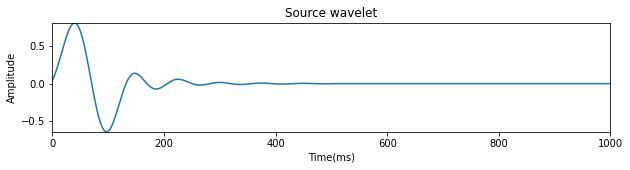

In [72]:
# Read source wavelet
filename='Marm2D-RawSign.sgy'
with segyio.open(filename, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000
    n_samples = f.samples.size
    time = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    trace=data[0]
# Plot source wavelet
    fig = plt.figure(figsize=(10, 2))
    ax = fig.add_subplot(111)
    ax.plot(time,trace)
    ax.set_xlim(0,1000)
    ax.set_ylim(np.min(trace),np.max(trace))
    ax.set_xlabel('Time(ms)')
    ax.set_ylabel('Amplitude')
    ax.set_title('Source wavelet')

# Plot the data

We use synthetic data generated by solving the forward problem (the acoustic wave equation) in the true velocity model. We will call this the "field data" in the rest of the exercise but remember that it is not real data. This is similar to what we did in the travel time exercise, where our "data" was also generated through the true model.

By using synthetic data we are making the problem considerably easier than it is with field data. There are several complicating factors that we have removed.
- The data contain no noise. In real field applications the data always contain noise. The main sources of noise are wind waves, turbulence from the ship and from dragging the gear through the water, electronic noise.
- The sources and receivers are perfectly located. In real cases the location of the sources and receivers is subject to uncertainties that lead to errors propagating through the inversion
- The physics is simplified. By using the acoustic wave equation we are disregarding elastic and anelatic effects that affect the amplitude of the seismic waves.
- There is no anisotropy. The real Earth is anisotropic (Vp depends on the azimuth in which you measure it). If this is not taken into account it leads to inconsitencies between different parts of the dataset.

Below we plot the shot gather for one of the shots placed about 1/3 of the way across the profile.

**Question 1.** Spend some time looking at the data section. You can plot a different shot by changing the variable "shot" below. This should be a number between 1 and 15.
Identify the following seismic phases:
- Direct waves i.e. waves travelling through the water straight to the receiver
- Seabed reflection
- Deeper reflections
- Transmitted waves (refraction)
You can take a screenshot of the data plot and mark these phases on the plot using powerpoint.


N Traces: 5565, N Samples: 1250, Sample rate: 2.4ms
The 99th percentile is 1; the max amplitude is 82


Text(0.5, 1.0, 'Shot number 6')

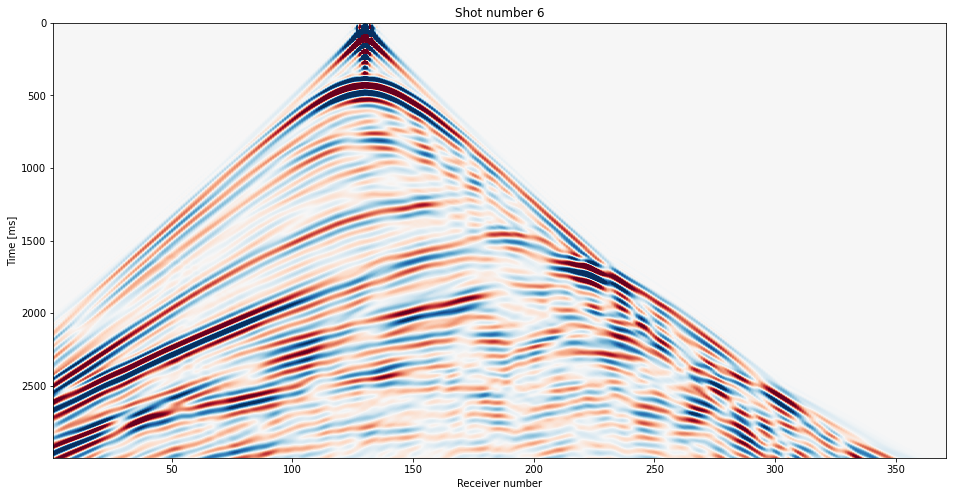

In [73]:
# Data filename
filename='Marm2D-Synthetic.sgy'
# Open data file
with segyio.open(filename, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000
    n_samples = f.samples.size
    time = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
print(f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms')
# Select amplitude cutoff for plotting
clip_percentile = 99
vm = np.percentile(data, clip_percentile)
print(f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {data.max():.0f}')

# Select shot to plot
shot=6
trace1=nrecs*(shot-1)
trace2=nrecs*shot

# Plot shot gather
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
extent = [1, nrecs, time[-1], time[0]]  # define extent
ax.imshow(data.T[:,trace1:trace2], cmap="RdBu", vmin=-vm, vmax=vm, aspect='auto',extent=extent)
ax.set_xlabel('Receiver number')
ax.set_ylabel('Time [ms]')
ax.set_title(f'Shot number {shot}')

# True model and starting model

The true model is the Marmousi model. The starting model in this case is obtained by smoothing the true model and adding a small bias. In real cases the starting model may be generated by travel time tomography or from the stacking velocities from processing of reflection data.

**Question 2.** Why is it important to have a good starting model in full waveform inversion? What does "good" mean in this case? How do we check that the starting model is "good"?

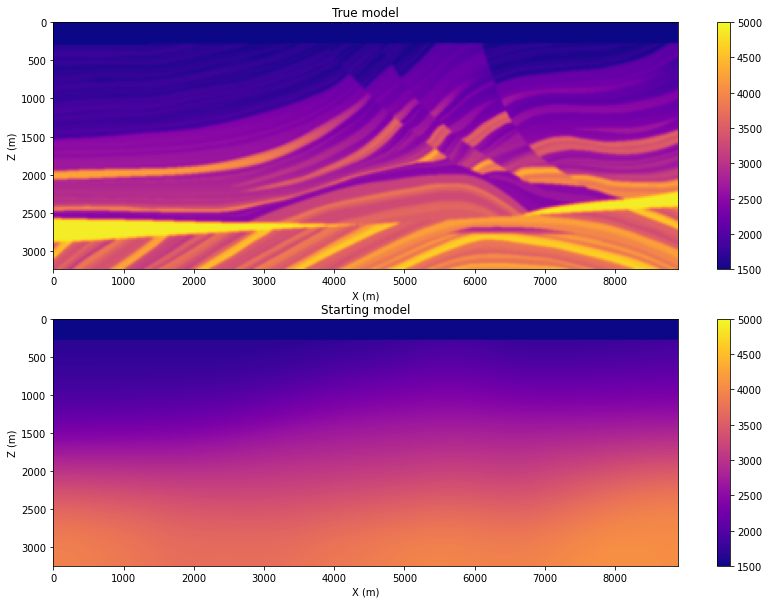

In [74]:
filename='Marm2D-TrueVp.sgy'
with segyio.open(filename, ignore_geometry=True) as f:
    vptrue = f.trace.raw[:]  # Get all data into memory (could cause issues on big files)

filename='Marm2D-StartVp.sgy'
with segyio.open(filename, ignore_geometry=True) as f:
    depth = f.samples
    vpstart = f.trace.raw[:]  # Get all data into memory (could cause issues on big files)

#print(f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms')

fig = plt.figure(figsize=(14, 10))

ax1 = fig.add_subplot(2, 1, 1)
extent = [0, nrecs*dx, depth[-1], depth[0]]  # define extent
im1=ax1.imshow(vptrue.T, cmap="plasma", vmin=1500, vmax=5000, aspect='auto',extent=extent)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Z (m)')
ax1.set_title('True model')
plt.colorbar(im1)

ax2 = fig.add_subplot(2, 1, 2)
extent = [0, nrecs*dx, depth[-1], depth[0]]  # define extent
im2=ax2.imshow(vpstart.T, cmap="plasma", vmin=1500, vmax=5000, aspect='auto',extent=extent)
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Z (m)')
ax2.set_title('Starting model')
plt.colorbar(im2)

# The wavefield

The wavefield describes the pressure field generated by the source. Below we read and plot the wavefield for shot number 6 computed in the first iteration. Running this box will show a short animation of the waves propagating through the model (here you can only see the wavefield for shot 6 as the data provided does not contain the wavefield for the other shots, to keep the disk storage requirements small). 

**Question 3.** The wavefield shown for iteration 1 is very simple, with just a transmitted wave and some water column multiples. It is computer by solving the acoustic wave equation. What are the main simplifications made in this case, compared to the real Earth? How would the wavefield be different in the real Earth?

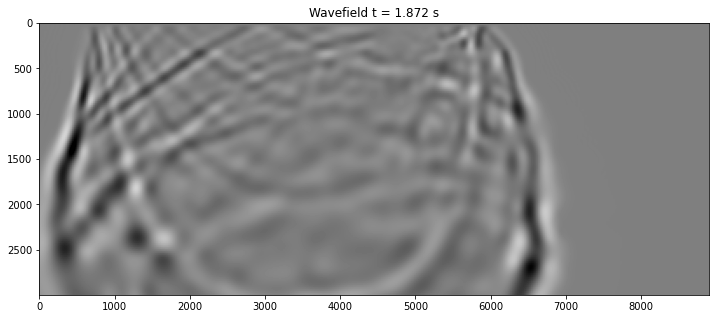

In [97]:
%matplotlib inline
from IPython.display import clear_output
from time import sleep

xtratop=0
xtrabot=50
xtra1=50
nx3w=nx3+xtratop+xtrabot
nx1w=nx1+2*xtra1

extent = [0, nrecs*dx, time[-1], time[0]]  # define extent
timesteps=np.arange(20,800,20,dtype=int)
#timesteps=np.arange(1240,500,-20,dtype=int)

shot=6
iteration=1
iterstr=str(iteration).zfill(5)
shotstr=str(shot).zfill(5)
xcorr=np.zeros((nx1,nx3))
for step in timesteps:
    fig = plt.figure(figsize=(12, 5))
    ax=plt.subplot(111)
    timestr=str(step).zfill(6)
    filename='fw-'+timestr+'-csref'+shotstr+'-iter'+iterstr+'fwd1.vtr'
    !./read_vtr <<< {filename} >& tmp
    binfile=filename+".bin"
    fw=np.fromfile(binfile, dtype=np.float32)
    fw=np.reshape(fw,(nx1w,nx3w))
    fw=fw[xtra1:-xtra1,xtratop:-xtrabot]
    clear_output(wait=True)
    plt.imshow(fw.T, cmap="gray",vmin=-70,vmax=70,aspect='auto',extent=extent)
    ax.set_title('Wavefield t = '+str(step*sample_rate/1000)+' s')

    plt.show()
    sleep(0.03)

# Data misfit (residuals)

The wavefield is defined everywhere in the model. We are interested in the value fo the wavefield at the receivers because this is all that can be measured. We extract the predicted wavefield at the receiver locations to generate synthetics. This gives us shot gathers that we can compare to the field data. Below we plot the synthetics, the data and the residuals. The residuals are simply calculated by subtracting the data from the synthetics. Notice how the synthetics are much simpler and don't contain all the complex reflections seen in the data.

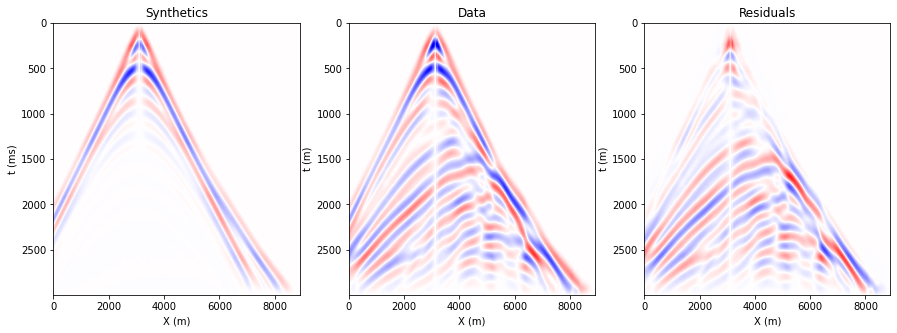

In [64]:

ntraces=nrecs*3
x1=0
x2=371

for step in ["01"]:
    filename='compare_6_'+step+'.bin'
    traces=np.fromfile(filename, dtype=np.float32)
    traces=np.reshape(traces,(ntraces,n_samples))
    

    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 3, 1)
    extent = [x1, x2*dx, time[-1], time[0]]  # define extent
    ax1.imshow(traces.T[:,x1:x2], cmap="seismic",vmin=-0.2,vmax=0.2,aspect='auto',extent=extent)
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('t (ms)')
    ax1.set_title('Synthetics')
    ax1 = fig.add_subplot(1, 3, 2)
    extent = [x1, x2*dx, time[-1], time[0]]  # define extent
    ax1.imshow(traces.T[:,nrecs+x1:nrecs+x2], cmap="seismic",vmin=-0.2,vmax=0.2,aspect='auto',extent=extent)
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('t (m)')
    ax1.set_title('Data')
    ax1 = fig.add_subplot(1, 3, 3)
    extent = [x1, x2*dx, time[-1], time[0]]  # define extent
    ax1.imshow(traces.T[:,2*nrecs+x1:2*nrecs+x2], cmap="seismic",vmin=-0.2,vmax=0.2,aspect='auto',extent=extent)
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('t (m)')
    ax1.set_title('Residuals')

# Trace comparison

The mismatch between data and synthetics can also be seen by plotting one of the traces as a wiggle. Below we plot the data in black and the synthetics in blue for shot number 6 recorded on receiver number 180.

Notice how the first couple of peaks are predicted reasonably well, these peaks correspond to the refracted arrivals. The fact that their timing is predicted accurately means that our starting model is adequate. This is not surprising given that our starting model was generated by simply smoothing the true model and adding a small bias. We also have the advantage of having good low frequency data (comapared to the size of the model) and no noise. The later arrivals are not present in the synthetics because there are no sharp boundaries to generate the reflections.

Text(0.5, 1.0, 'Trace comparison')

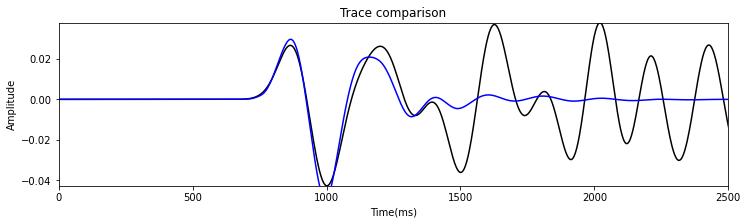

In [65]:
tracenum=180
datatrace=traces[nrecs+tracenum,:]
syntrace=traces[tracenum,:]

fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(111)
ax.plot(time,datatrace,'black')
ax.plot(time,syntrace,'blue')

ax.set_xlim(0,2500)
ax.set_ylim(np.min(datatrace),np.max(datatrace))
ax.set_xlabel('Time(ms)')
ax.set_ylabel('Amplitude')
ax.set_title('Trace comparison')


# The residual wavefield

To compute the gradient of the objective function we need to first compute the back-propagated residual wavefield. This consists of turning the receivers into sources and the residuals into source time functions.

Notice how all the receivers act as sources at the same time. This is done to save computational cost.


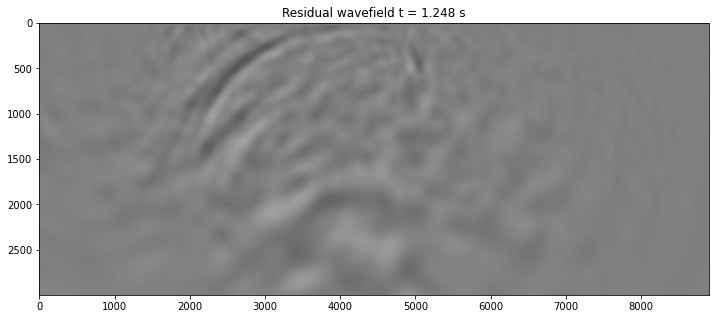

In [96]:
%matplotlib inline
from IPython.display import clear_output
from time import sleep

xtratop=0
xtrabot=50
xtra1=50
nx3w=nx3+xtratop+xtrabot
nx1w=nx1+2*xtra1

extent = [0, nrecs*dx, time[-1], time[0]]  # define extent
timesteps=np.arange(1240,500,-20,dtype=int)

iteration=1
iterstr=str(iteration).zfill(5)
shotstr=str(shot).zfill(5)
xcorr=np.zeros((nx1,nx3))
for step in timesteps:
    fig = plt.figure(figsize=(12, 5))
    ax=plt.subplot(111)
    timestr=str(step).zfill(6)
    filename='bw-'+timestr+'-csref'+shotstr+'-iter'+iterstr+'fwd1.vtr'
    !./read_vtr <<< {filename} >& tmp
    binfile=filename+".bin"
    bw=np.fromfile(binfile, dtype=np.float32)
    bw=np.reshape(bw,(nx1w,nx3w))
    bw=bw[xtra1:-xtra1,xtratop:-xtrabot]
    clear_output(wait=True)
    plt.imshow(bw.T, cmap="gray",vmin=-0.1,vmax=0.1,aspect='auto',extent=extent)
    ax.set_title('Residual wavefield t = '+str(step*sample_rate/1000)+' s')
    plt.show()
    sleep(0.03)

# Cross-correlation

The cross-correlation is equivalent to multiplying the forward and residual wavefields at each time step and then summing all the timesteps together. First we look at the product of the forward and residual fields:

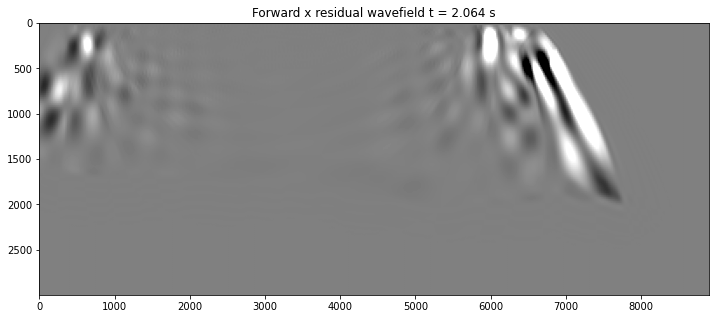

In [85]:
%matplotlib inline
from IPython.display import clear_output
from time import sleep

xtratop=0
xtrabot=50
xtra1=50
nx3w=nx3+xtratop+xtrabot
nx1w=nx1+2*xtra1

extent = [0, nrecs*dx, time[-1], time[0]]  # define extent
timesteps=np.arange(20,880,20,dtype=int)
#timesteps=np.arange(1240,500,-20,dtype=int)

iteration=1
iterstr=str(iteration).zfill(5)
shotstr=str(shot).zfill(5)
xcorr=np.zeros((nx1,nx3))
for step in timesteps:
    fig = plt.figure(figsize=(12, 5))
    ax = plt.subplot(111)
    timestr=str(step).zfill(6)
    filename='fw-'+timestr+'-csref'+shotstr+'-iter'+iterstr+'fwd1.vtr'
    !./read_vtr <<< {filename} >& tmp
    binfile=filename+".bin"
    fw=np.fromfile(binfile, dtype=np.float32)
    fw=np.reshape(fw,(nx1w,nx3w))
    fw=fw[xtra1:-xtra1,xtratop:-xtrabot]
    filename='bw-'+timestr+'-csref'+shotstr+'-iter'+iterstr+'fwd1.vtr'
    !./read_vtr <<< {filename} >& tmp
    binfile=filename+".bin"
    bw=np.fromfile(binfile, dtype=np.float32)
    bw=np.reshape(bw,(nx1w,nx3w))
    bw=bw[xtra1:-xtra1,xtratop:-xtrabot]
    prod=bw*fw
    xcorr+=prod
    clear_output(wait=True)
    plt.imshow(prod.T, cmap="gray",vmin=-1,vmax=1,aspect='auto',extent=extent)
    ax.set_title('Forward times residual wavefield t = '+str(step*sample_rate/1000)+' s')

    plt.show()
    sleep(0.03)
    

We then look at the summed contribution of all time steps for this shot. We end up with a pattern of positive and negative amplitudes that correspond to regions where the forward and residual wavefields are correlated.

Text(0.5, 1.0, 'Gradient contribution from shot 6')

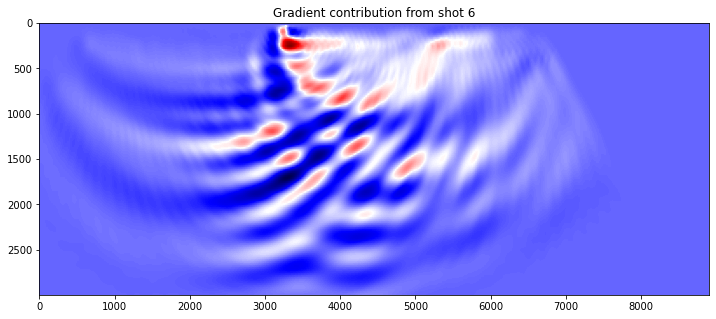

In [87]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 1, 1)
extent = [0, nrecs*dx, time[-1], time[0]]  # define extent
im=plt.imshow(xcorr.T, cmap="seismic",aspect='auto',extent=extent)
ax1.set_title('Gradient contribution from shot '+str(shot))


# The gradient

If we sum together the contributions of all sources we get the gradient of the objective function or the unscaled model update. It shows a coherent pattern that resembles the layering in the true model. The blue and red areas are where the starting model was incorrect and we need to increase or decrease the seismic velocity.



0.089824155


Text(0.5, 1.0, 'Gradient')

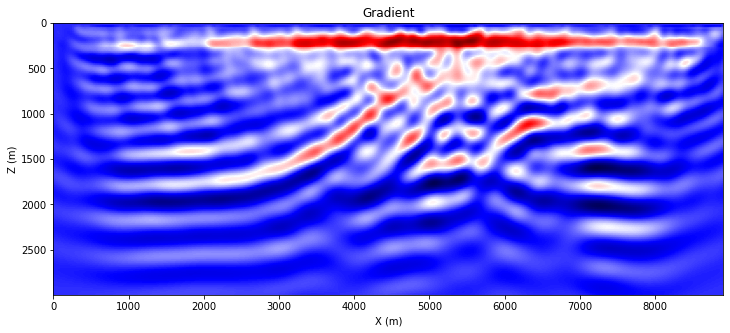

In [43]:
iteration=1
iterstr=str(iteration).zfill(5)
filename='Marm2D-CP'+iterstr+'-Grad.vtr'
!./read_vtr <<< {filename} >& tmp

xtratop=1
xtrabot=50
xtra1=50
nx3w=nx3+xtratop+xtrabot
nx1w=nx1+2*xtra1

binfile=filename+".bin"
grad=np.fromfile(binfile, dtype=np.float32)
grad=np.reshape(grad,(nx1w,nx3w))
grad=grad[xtra1:-xtra1,xtratop:-xtrabot]

print(np.max(grad))

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 1, 1)
extent = [0, nrecs*dx, time[-1], time[0]]  # define extent
ax1.imshow(grad.T, cmap="seismic",aspect='auto',extent=extent)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Z (m)')
ax1.set_title('Gradient')

# The step length

After we calculate the gradient we can add a small perturbation to the starting model in the direction of the gradient. We then solve the forward problem one more time (recalculate the synthetic data) and recomputer the residuals. This helps us determine the step length, i.e. the optimal magnitude of the model update. 

Once we have the step length we can update the model.

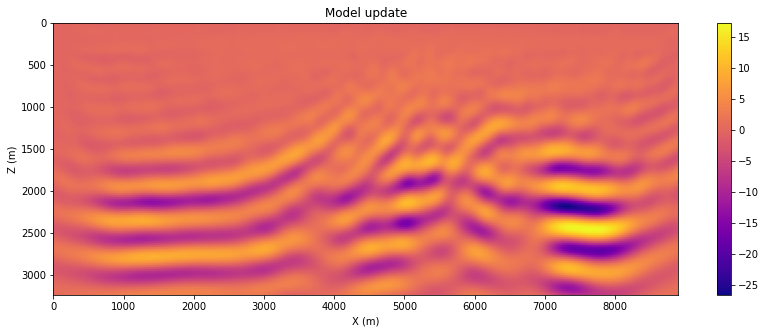

In [44]:
iteration=1
iterstr=str(iteration).zfill(5)
filename='Marm2D-CP'+iterstr+'-InvVp-Update.sgy'
# Read the slowness update
with segyio.open(filename, ignore_geometry=True) as f:
    slowupdate = f.trace.raw[:] 
    depth = f.samples
filename='Marm2D-CP'+iterstr+'-Vp.sgy'

# Read Vp the model
with segyio.open(filename, ignore_geometry=True) as f:
    vp = f.trace.raw[:] 
    depth = f.samples
# Calculate the Vp update
vpupdate=slowupdate*vp*vp
    
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(1, 1, 1)
extent = [0, nrecs*dx, depth[-1], depth[0]]  # define extent
im=ax1.imshow(vpupdate.T, cmap="plasma", aspect='auto',extent=extent)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Z (m)')
ax1.set_title('Model update')
fig.colorbar(im)

# Iteration procedure

Once we have updated the model we can iterate. In this case we have run 120 iterations. These are divided into blocks of 20 iterations. In each block we have increased the frequency of the signal that we allow, starting only with low frequencies. This ensures that we avoid cycle skipping and falling into local minima. 

Iterations | max frequency


---

1-20     |  3.0 Hz

21-40    |  3.4 Hz

41-60    |  3.9 Hz

61-80    |  4.5 Hz

81-100   |  5.2 Hz

101-120  |  6.0 Hz

Each iteration adds a bit more structure. We start with only the low frequency part of the data and then gradually add more of the signal as the inversion progresses.

Go back to the wavefield box and look at the wavefiled animation for iteration 20, 60 and 120. You can do this by changing the variable "iteration" and rerunning the box. Notice how the wavefield for the later iterations contains a lot more features and particularly several strong reflections.

# Data match

Here we look at how the data match has improved throughout the inversion. We plot the synthetics, data and residuals for iteration 1, 20, 60 and 120. Notice how by iteration 20 we can already predict the data very well. Subsequent iterations add higher frequency content and fit the smaller scale structure.

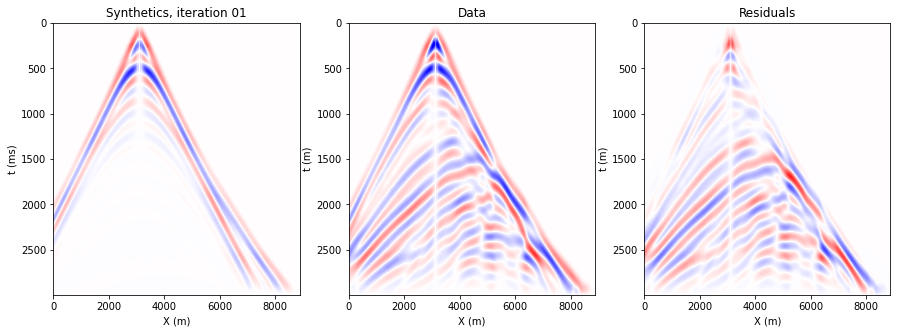

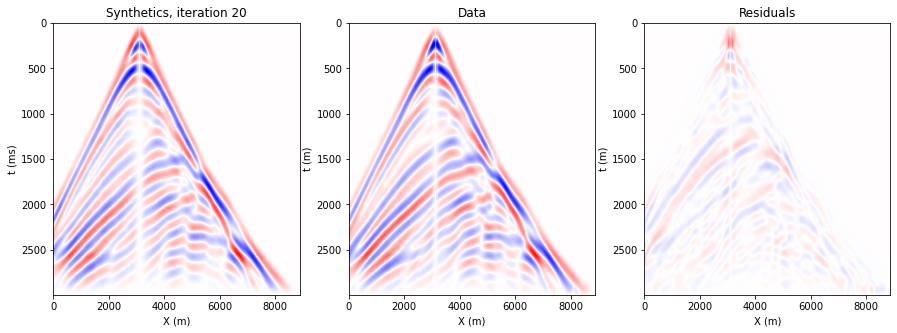

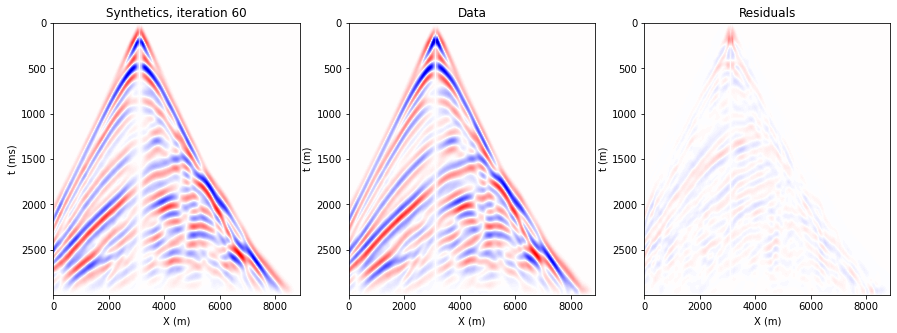

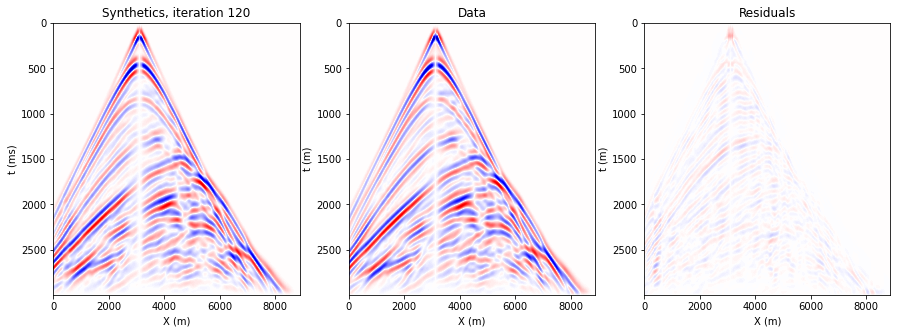

In [95]:

ntraces=nrecs*3
x1=0
x2=370
ampmin=-0.2
ampmax=0.2
for step in ["01","20","60","120"]:
    filename='compare_6_'+step+'.bin'
    traces=np.fromfile(filename, dtype=np.float32)
    traces=np.reshape(traces,(ntraces,n_samples))
    

    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 3, 1)
    extent = [x1, x2*dx, time[-1], time[0]]  # define extent
    ax1.imshow(traces.T[:,x1:x2], cmap="seismic",vmin=ampmin,vmax=ampmax,aspect='auto',extent=extent)
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('t (ms)')
    ax1.set_title('Synthetics, iteration '+str(step))
    ax1 = fig.add_subplot(1, 3, 2)
    extent = [x1, x2*dx, time[-1], time[0]]  # define extent
    ax1.imshow(traces.T[:,nrecs+x1:nrecs+x2], cmap="seismic",vmin=ampmin,vmax=ampmax,aspect='auto',extent=extent)
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('t (m)')
    ax1.set_title('Data')
    ax1 = fig.add_subplot(1, 3, 3)
    extent = [x1, x2*dx, time[-1], time[0]]  # define extent
    ax1.imshow(traces.T[:,2*nrecs+x1:2*nrecs+x2], cmap="seismic",vmin=ampmin,vmax=ampmax,aspect='auto',extent=extent)
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('t (m)')
    ax1.set_title('Residuals')


# Trace match

As a last check we look at how the trace match has improved. Notice that the final traces contain higher frequency because we have gradually increased the frequency bandwidth of the the data and source by adding higher frequencies as we progressed in the inversion.

Text(0.5, 0, 'Time(ms)')

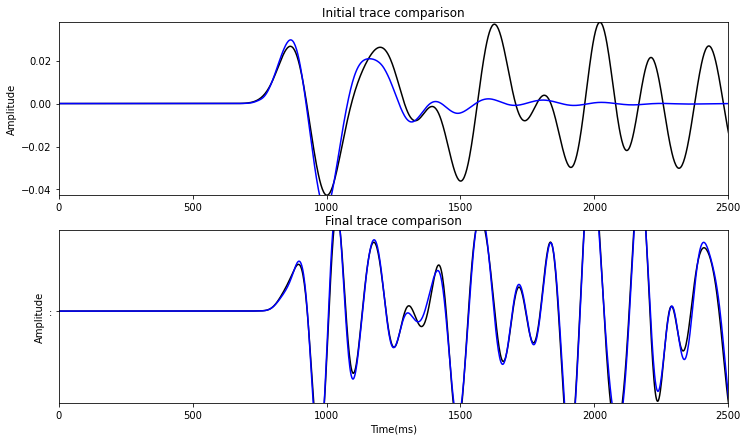

In [48]:
finaldatatrace=traces[nrecs+tracenum,:]
finalsyntrace=traces[tracenum,:]

fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(211)
ax1.plot(time,datatrace,'black')
ax1.plot(time,syntrace,'blue')
ax1.set_xlim(0,2500)
ax1.set_ylim(np.min(datatrace),np.max(datatrace))
ax1.set_ylabel('Amplitude')
ax1.set_title('Initial trace comparison')

ax2 = fig.add_subplot(212)
ax2.plot(time,finaldatatrace,'black',":")
ax2.plot(time,finalsyntrace,'blue',":")
ax2.set_xlim(0,2500)
ax2.set_ylim(np.min(datatrace),np.max(datatrace))
ax2.set_ylabel('Amplitude')
ax2.set_title('Final trace comparison')
ax2.set_xlabel('Time(ms)')



# Output velocity models

We can then have a look at how the starting model has changed. The box below will plot a comparison of the true model and output model. You can change the variable "iternum" to plot the output model for different steps (choose for example iterations 20, 40, 60, 80, 100, 120 to look at the result after each block of iterations).


Text(0.5, 1.0, 'Iteration 120')

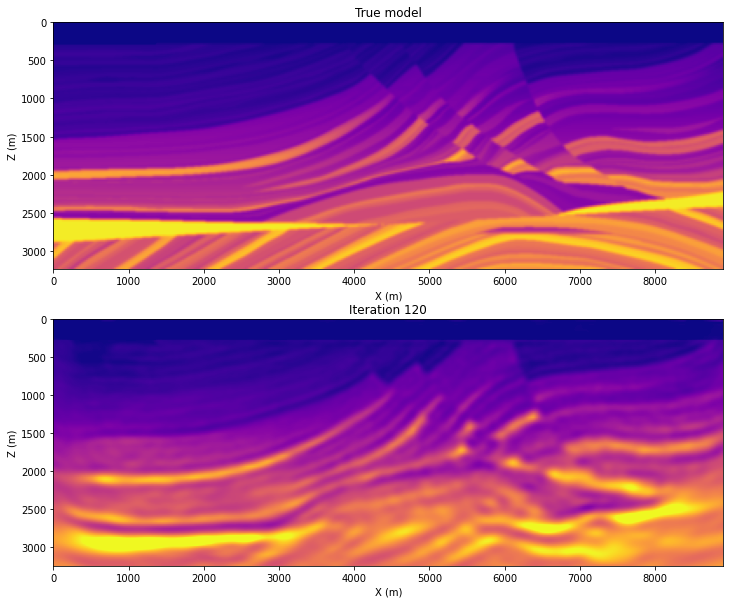

In [90]:
iternum=120

filename='Marm2D-TrueVp.sgy'
with segyio.open(filename, ignore_geometry=True) as f:
    vptrue = f.trace.raw[:]  # Get all data into memory (could cause issues on big files)

iterstr=str(iternum).zfill(5)
filename='Marm2D-CP'+iterstr+'-Vp.sgy'
with segyio.open(filename, ignore_geometry=True) as f:
    # Get basic attributes
    depth = f.samples
    vpstart = f.trace.raw[:]  # Get all data into memory (could cause issues on big files)

fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(2, 1, 1)
extent = [0, nrecs*dx, depth[-1], depth[0]]  # define extent
ax1.imshow(vptrue.T, cmap="plasma", vmin=1500, vmax=5000, aspect='auto',extent=extent)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Z (m)')
ax1.set_title('True model')

ax2 = fig.add_subplot(2, 1, 2)
extent = [0, nrecs*dx, depth[-1], depth[0]]  # define extent
ax2.imshow(vpstart.T, cmap="plasma", vmin=1500, vmax=5000, aspect='auto',extent=extent)
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Z (m)')
ax2.set_title('Iteration '+str(iternum))


**Question 5** Remembering that the theoretical resolution limit for full waveform inversion is half the wavelength, what is the expected best resolution for the final model (iteration 120 with data up to 6 Hz)? How does that compare to the resolution at the end of the first block (iteration 20 with data up to 3 Hz)? Compare this with the theoretical resolution of travel time tomography (given by the width of the Fresnel volume). Recall that the Fresnel volume is approximately equal to the square root of the product of the wavelength and the offset.

This theoretical resolution limit corresponds to the "physical resolution discussed in video 3 of session 5. It depends on the physical process that we measure. It does not account for the data distribution and the illumination of the target (the data resolution).

# Final considerations

**Question 6** In question 5 you have determined the theoretical best resolution that you can expect from this inversion. How would you determine the "model resolution"?

**Question 7** Examine the comparison between the true model and the output model from iteration 120. Notice how the match varies spatially. What affects the variations in the quality of the model?

